### AUTOENCODERS FOR GENERATOR
##### convolutional autoencoder, variational autoencoder, u-net, residual u-net, recurrent u-net, r2u-net

In [2]:
import sys
sys.path.append('../')
import src

Using TensorFlow backend.


In [3]:
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, '/Users/jlee/Desktop/JONG/TUM/18W/\
Advanced_Deep_Learning_for_Computer_Vision/project/data')

In [4]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11756980278351801819
]


In [5]:
inputs = src.get_data(sys.path[0]+"/RW-201008", total_length=101)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jlee/Desktop/JONG/TUM/18W/Advanced_Deep_Learning_for_Computer_Vision/project/data/RW-201008'

In [6]:
# images = src.generate_datasets(inputs, n=1000, size=64, length=2, normalize=True, split=(6,2,2))
images = np.load(sys.path[0]+"/dataset.npy").item()
# images

In [7]:
#low_res_train = images["low_res_train"]
#low_res_xval = images["low_res_xval"]
#low_res_test = images["low_res_test"]
#overfit = np.reshape(images['images'],np.shape(images['images'])+(1,))
train = np.reshape(images["train"],np.shape(images["train"])+(1,))
xval = np.reshape(images["xval"],np.shape(images["xval"])+(1,))
test = np.reshape(images["test"],np.shape(images["test"])+(1,))
print(f"Training data: {train.shape}\nValidation data: {xval.shape}\nTest data: {test.shape}")

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


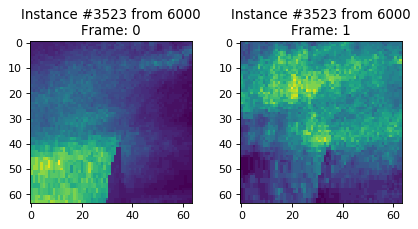

In [8]:
%matplotlib inline
src.visualise_data(train[:,:,:,:,0])

In [9]:
train[:,0,:,:,:].shape, xval[:,0,:,:,:].shape

((6000, 64, 64, 1), (2000, 64, 64, 1))

In [63]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,)+train.shape[2:]))
overfit_train.shape

(1, 64, 64, 1)

In [85]:
images_5min = np.load(sys.path[0]+"/5_minute.npy").item()
train_5min = np.reshape(images_5min["train"],np.shape(images_5min["train"])+(1,))
val_5min = np.reshape(images_5min["xval"],np.shape(images_5min["xval"])+(1,))
test_5min = np.reshape(images_5min["test"],np.shape(images_5min["test"])+(1,))
print(f"Training data: {train.shape}\nValidation data: {xval.shape}\nTest data: {test.shape}")

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


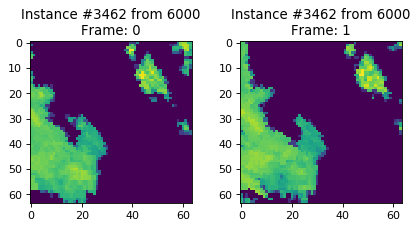

In [86]:
%matplotlib inline
src.visualise_data(train_5min[:,:,:,:,0])

#### BASIC CONVOLUTIONAL AUTOENCODER

##### USE MAXPOOLING AND UPSAMPLING

In [89]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(64, 64, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 16, 16, 32)        128       
__________

In [90]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [91]:
autoencoder.fit(overfit_train, overfit_truth,
                epochs=2000,
                batch_size=1,
                shuffle=True)
                #validation_data=(xval[:,0,:,:,:], xval[:,1,:,:,:]))

Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0877
Epoch 2/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.0371
Epoch 3/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.0153
Epoch 4/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.0116
Epoch 5/2000
1/1 [==============================] - 0s 18ms/step - loss: 0.0079
Epoch 6/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.0072
Epoch 7/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.0064
Epoch 8/2000
1/1 [==============================] - 0s 21ms/step - loss: 0.0053
Epoch 9/2000
1/1 [==============================] - 0s 18ms/step - loss: 0.0051
Epoch 10/2000
1/1 [==============================] - 0s 19ms/step - loss: 0.0046
Epoch 11/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.0039
Epoch 12/2000
1/1 [==============================] - 0s 21ms/step - loss: 0.0036
Epoch 13/2000
1/1 [====================

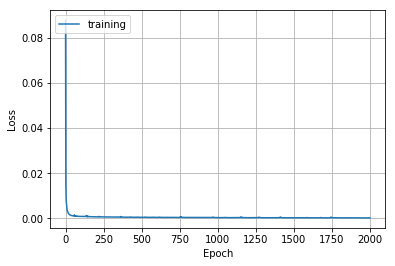

In [92]:
hist = autoencoder.history
hist.history.keys()
plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [93]:
overfit_prediction = autoencoder.predict(overfit_train, batch_size=1)
overfit_prediction.shape

(1, 64, 64, 1)

../src.py:198: RuntimeWarning: divide by zero encountered in true_divide
  images = np.zeros_like(truth)


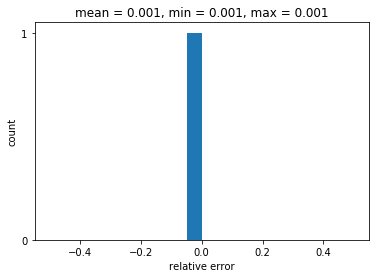

In [94]:
args = src.arg_getter(overfit_truth, overfit_prediction)
error_images, error_vals, error_means = src.error_distribution(overfit_truth, overfit_prediction, metric="relative_error")

In [95]:
error_images.shape

(1, 64, 64, 1)

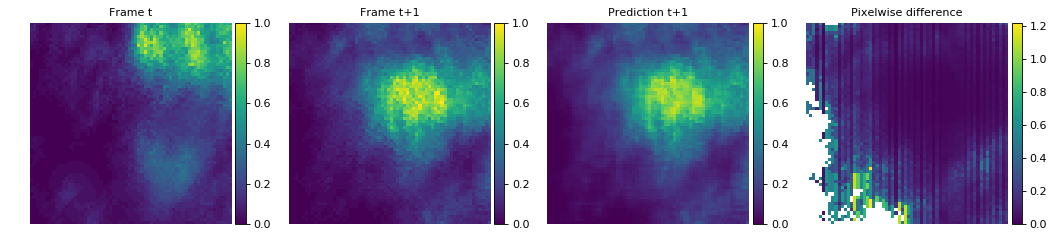

In [96]:
result_plotter(args, (overfit_train[:,:,:,0], overfit_truth[:,:,:,0], overfit_prediction[:,:,:,0], error_images[:,:,:,0]))

In [97]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adam', loss=custom_loss, metrics=[src.relative_error_tensor])
callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),\
            keras.callbacks.ModelCheckpoint(filepath='cae_5min_50.h5', monitor='val_loss', save_best_only=True)]

autoencoder.fit(train_5min[:,0,:,:,:], train_5min[:,1,:,:,:],
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=(val_5min[:,0,:,:,:], val_5min[:,1,:,:,:]),
                callbacks=callback)

Tensor("metrics_8/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_154_target_1:0", shape=(?, ?, ?, ?), dtype=float32)
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
6000/6000 [==============================] - 54s 9ms/step - loss: 0.0944 - relative_error_tensor: 0.3961 - val_loss: 0.0904 - val_relative_error_tensor: 0.3804
Epoch 2/50
6000/6000 [==============================] - 59s 10ms/step - loss: 0.0822 - relative_error_tensor: 0.3250 - val_loss: 0.0831 - val_relative_error_tensor: 0.3405
Epoch 3/50
6000/6000 [==============================] - 60s 10ms/step - loss: 0.0787 - relative_error_tensor: 0.3013 - val_loss: 0.0799 - val_relative_error_tensor: 0.3118
Epoch 4/50
6000/6000 [==============================] - 66s 11ms/step - loss: 0.0777 - relative_error_tensor: 0.2961 - val_loss: 0.0771 - val_relative_error_tensor: 0.2974
Epoch 5/50
6000/6000 [==============================] - 62s 10ms/step - loss: 0.0768 - relative_error_tensor: 0.2901 - va

In [25]:
# autoencoder.save("cae_50.h5")

In [98]:
# autoencoder.load_weights("cae_50.h5")

ValueError: You are trying to load a weight file containing 11 layers into a model with 13 layers.

In [26]:
hist = autoencoder.history
hist.history.keys()

dict_keys(['val_loss', 'loss'])

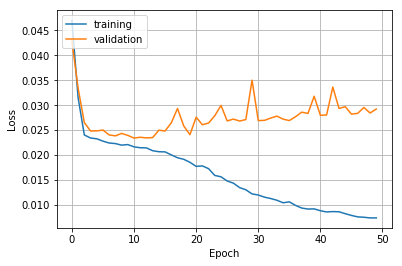

In [27]:
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [29]:
predictions = autoencoder.predict(test[:,0,:,:,:], batch_size=100)
truth       = test[:,1,:,:,:]
truth.shape

(2000, 64, 64, 1)

In [30]:
args = src.arg_getter(truth, predictions)
args[-1]

../src.py:198: RuntimeWarning: divide by zero encountered in true_divide
  images[i, :, :, :] = np.divide(num, den)


741

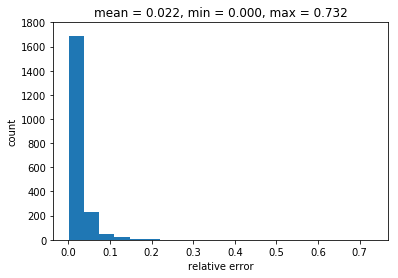

In [31]:
error_images, error_vals, error_means = src.error_distribution(truth, predictions, metric="relative_error")

In [37]:
test[:,0,:,:,0].shape, truth[:,:,:,0].shape, predictions[:,:,:,0].shape, error_images[:,:,:,0].shape

((2000, 64, 64), (2000, 64, 64), (2000, 64, 64), (2000, 64, 64))

In [38]:
def result_plotter(indices, datasets, task='prediction'):

    if task == 'prediction':
        title = ['Frame t', 'Frame t+1', 'Prediction t+1', 'Pixelwise difference']
    elif task == 'upsampling':
        title = ['Original', 'Downsampled', 'Upsampled', 'Pixelwise difference']
    else:
        sys.exit("Task must be 'prediction' or 'upsampling'.")
    for i in indices:
        fig, axes = plt.subplots(nrows=1, ncols=4, num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
        for j, ax in enumerate(axes.flat):
            im = ax.imshow(datasets[j][int(i)], vmin=0,
                           vmax=max([np.max(dset[int(i)]) for dset in datasets[:2]]) if int(j) < 3 else None)
                           #, norm=colors.PowerNorm(gamma=0.5) if int(j) == 3 else None)
            ax.set_title(f"{title[j]}", fontsize=10)
            colorbar(im)
            ax.axis('off')
        plt.savefig(f"Sample_{i}.png")
    plt.show()
    
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)


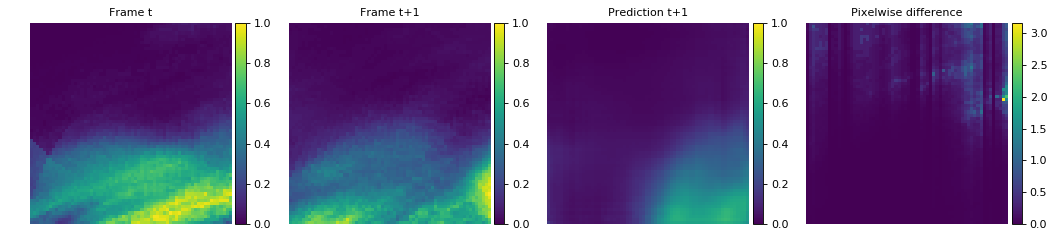

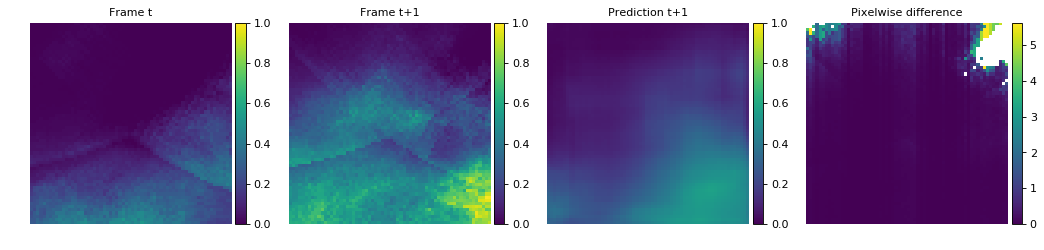

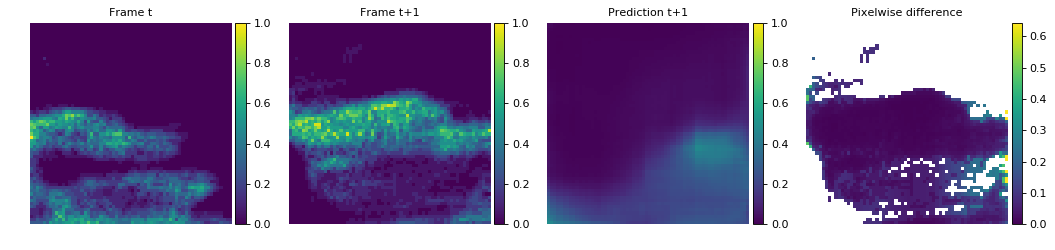

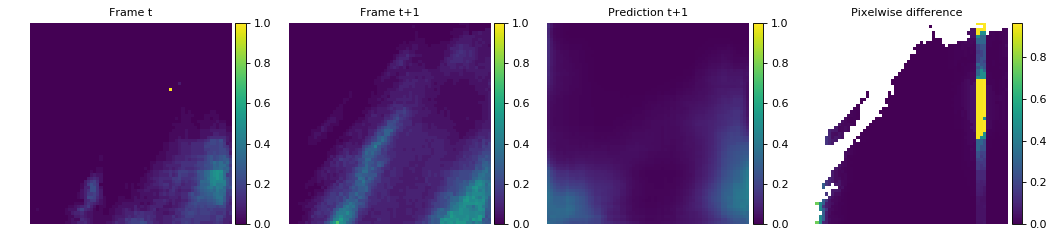

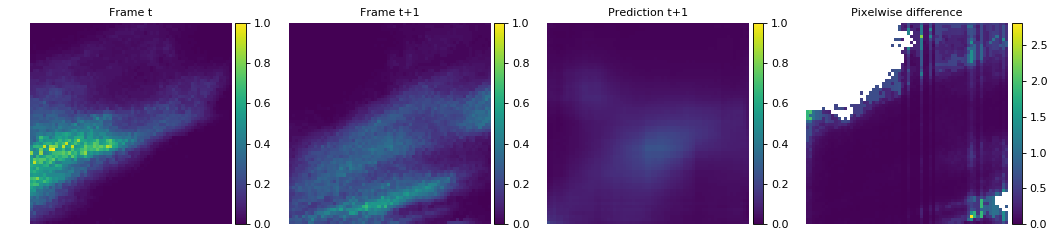

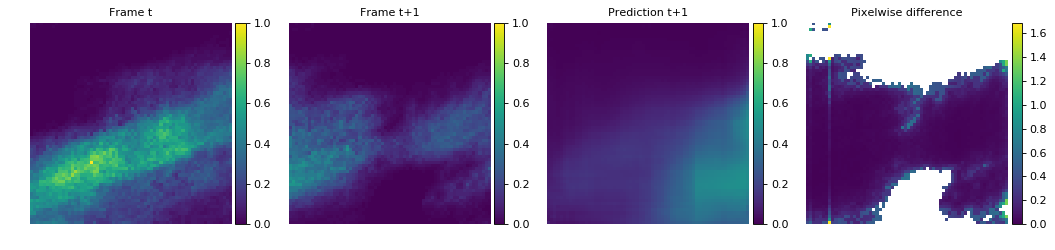

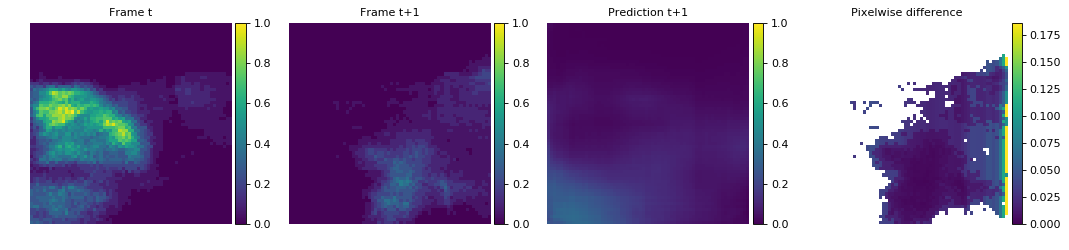

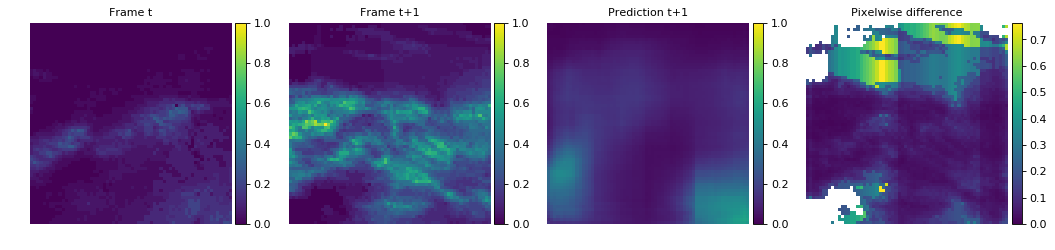

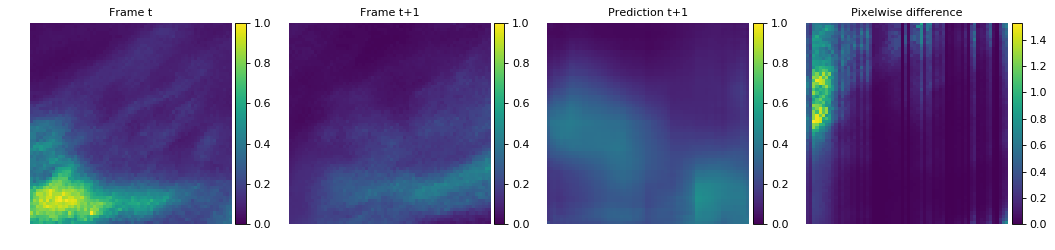

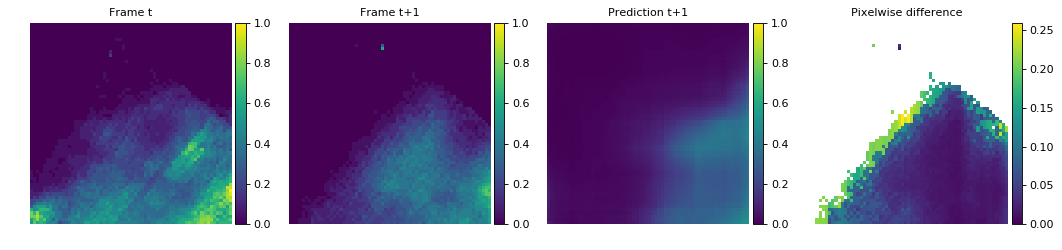

In [39]:
result_plotter(args[:10], (test[:,0,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))

##### 5MIN RESOLUTION, ADD GRAD DIFF LOSS

In [99]:
hist = autoencoder.history
hist.history.keys()

dict_keys(['val_loss', 'val_relative_error_tensor', 'loss', 'relative_error_tensor'])

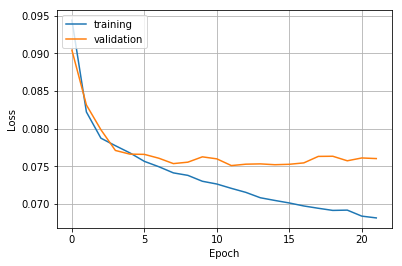

In [100]:
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [101]:
predictions = autoencoder.predict(test_5min[:,0,:,:,:], batch_size=100)
truth       = test_5min[:,1,:,:,:]
truth.shape

(2000, 64, 64, 1)

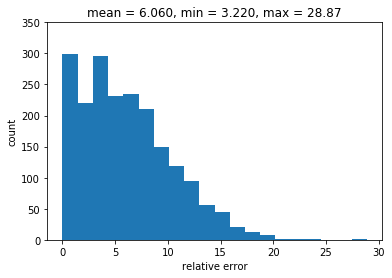

In [106]:
args = src.arg_getter(truth, predictions)
error_images, error_vals, error_means = src.error_distribution(truth, predictions, metric="difference")

In [108]:
args[-1]

316

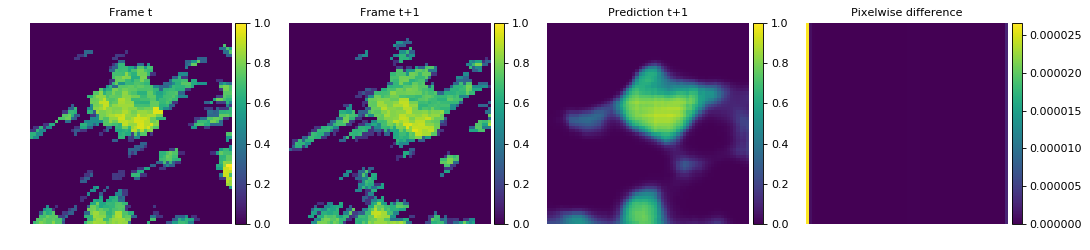

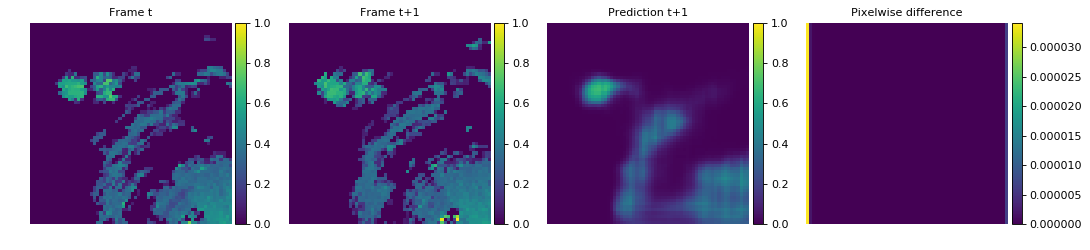

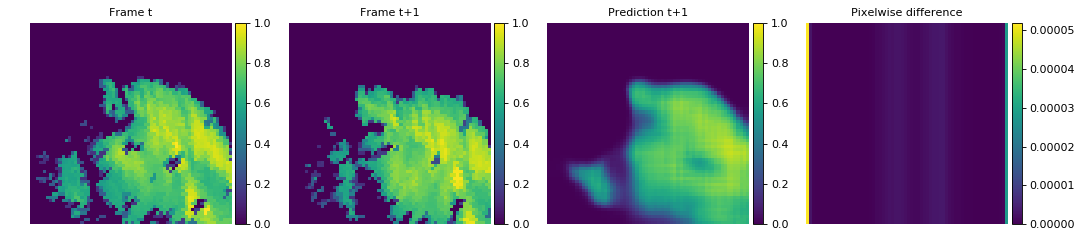

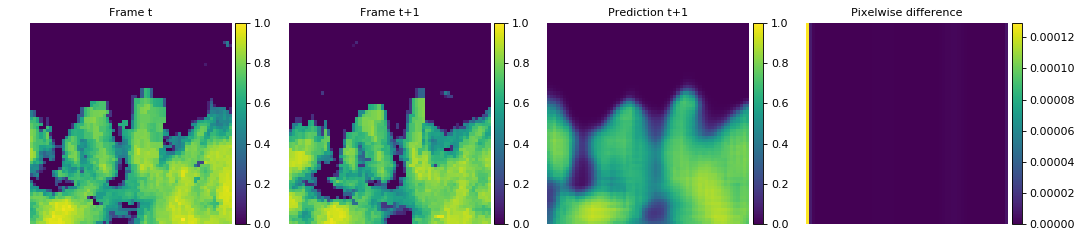

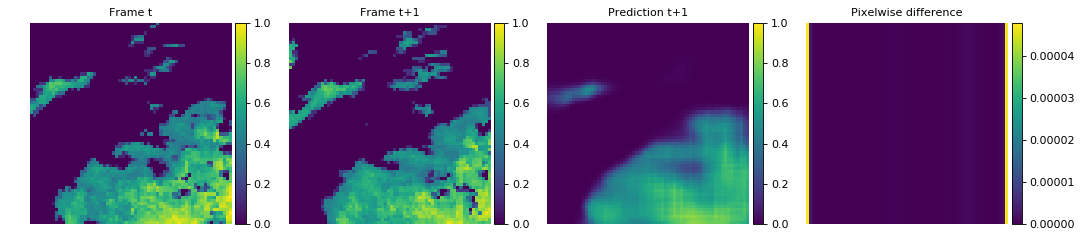

In [109]:
result_plotter(args[:5], (test_5min[:,0,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))

##### SAME NETWORK WITH LSTM BUT NO LSTM LAYER.

In [53]:
from keras.layers import Activation, BatchNormalization, Conv2DTranspose

input_img = Input(shape=(64, 64, 1))

x = Conv2D(8, (5, 5), strides=2, activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(16, (5, 5), strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (5, 5), strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded =  Conv2D(128, (5, 5), strides=4, activation='tanh', padding='same')(x)

x = Conv2DTranspose(64, (5, 5), strides=4, activation='relu', padding='same')(encoded)
x = Conv2DTranspose(32, (5, 5), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (5, 5), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(8, (5, 5), strides=2, activation='relu', padding='same')(x)
decoded = Conv2DTranspose(1, (5, 5), strides=2, activation='relu', padding='same')(x)

ae_no_lstm = Model(input_img, decoded)
ae_no_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 32, 32, 8)         208       
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 16, 16, 16)        3216      
_________________________________________________________________
batch_normalization_44 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 8, 8, 32)          12832     
_________________________________________________________________
batch_normalization_45 (Batc (None, 8, 8, 32)          128       
__________

In [54]:
def gradient_diff(yTrue, yPred):
    alpha = 1
    if len(yTrue.shape) == 5 :
        true = K.pow(K.flatten(K.abs(K.abs(yTrue[:,:,1:,:,:] - yTrue[:,:,:-1,:,:]) -
                                     K.abs(yPred[:,:,1:,:,:] - yPred[:,:,:-1,:,:]))),alpha)
        pred = K.pow(K.flatten(K.abs(K.abs(yTrue[:,:,:,1:,:] - yTrue[:,:,:,:-1,:]) -
                                     K.abs(yPred[:,:,:,1:,:] - yPred[:,:,:,:-1,:]))),alpha)
    elif len(yTrue.shape) == 4 :
        true = K.pow(K.flatten(K.abs(K.abs(yTrue[:,1:,:,:] - yTrue[:,:-1,:,:]) -
                                     K.abs(yPred[:,1:,:,:] - yPred[:,:-1,:,:]))),alpha)
        pred = K.pow(K.flatten(K.abs(K.abs(yTrue[:,:,1:,:] - yTrue[:,:,:-1,:]) -
                                     K.abs(yPred[:,:,1:,:] - yPred[:,:,:-1,:]))),alpha)
    num = K.sum(true + pred)
    return num / tf.to_float((K.shape(true)[0] + K.shape(pred)[0]))

In [55]:
#callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
#            keras.callbacks.ModelCheckpoint(filepath='ae_best.h5', monitor='val_loss', save_best_only=True)]

def custom_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred) + gradient_diff(y_true, y_pred)

# autoencoder.load_weights("ae_best.h5")
ae_no_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[src.relative_error_tensor])

Tensor("metrics_4/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_transpose_37_target:0", shape=(?, ?, ?, ?), dtype=float32)


In [56]:
from keras.callbacks import TensorBoard

ae_no_lstm.fit(train[:,0,:,:,:], train[:,1,:,:,:],
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=(xval[:,0,:,:,:], xval[:,1,:,:,:]))

Train on 6000 samples, validate on 2000 samples
Epoch 1/50
6000/6000 [==============================] - 14s 2ms/step - loss: 0.0272 - relative_error_tensor: 0.9399 - val_loss: 0.0251 - val_relative_error_tensor: 0.9585
Epoch 2/50
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0232 - relative_error_tensor: 0.9029 - val_loss: 0.0255 - val_relative_error_tensor: 0.8946
Epoch 3/50
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0222 - relative_error_tensor: 0.8758 - val_loss: 0.0250 - val_relative_error_tensor: 0.9387
Epoch 4/50
6000/6000 [==============================] - 14s 2ms/step - loss: 0.0208 - relative_error_tensor: 0.8418 - val_loss: 0.0249 - val_relative_error_tensor: 0.8918
Epoch 5/50
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0192 - relative_error_tensor: 0.8011 - val_loss: 0.0260 - val_relative_error_tensor: 0.9017
Epoch 6/50
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0173 - relative_er

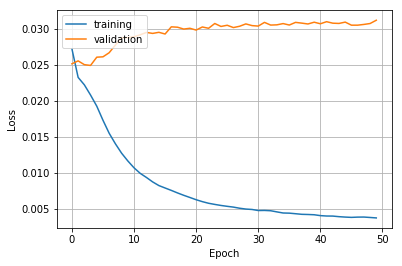

In [57]:
hist = ae_no_lstm.history
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [58]:
predictions = ae_no_lstm.predict(test[:,0,:,:,:], batch_size=100)
truth       = test[:,1,:,:,:]
truth.shape

(2000, 64, 64, 1)

In [59]:
args = src.arg_getter(truth, predictions)
args[-1]

306

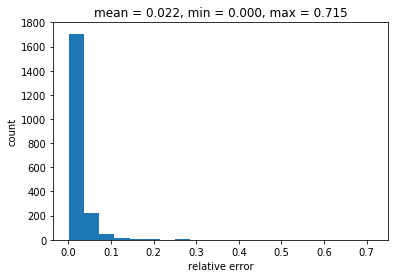

In [60]:
error_images, error_vals, error_means = src.error_distribution(truth, predictions, metric="relative_error")

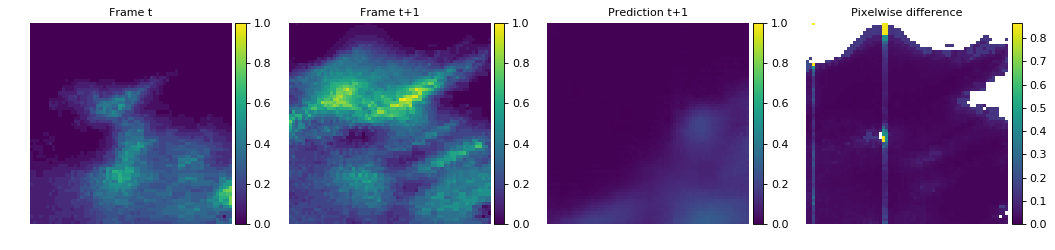

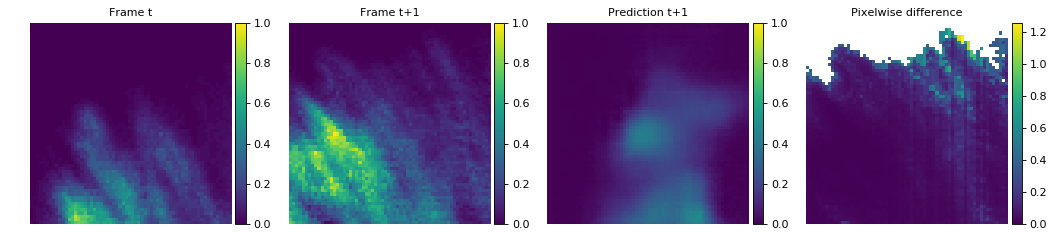

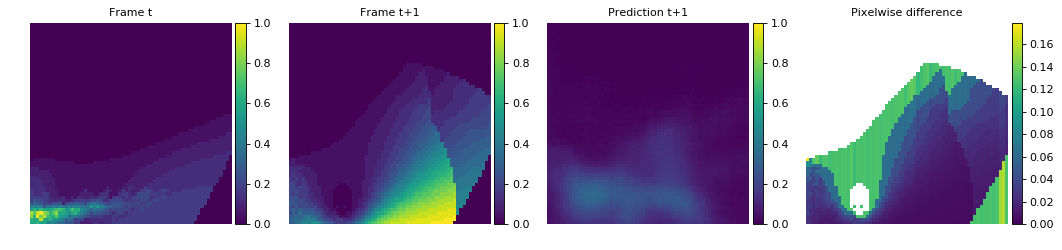

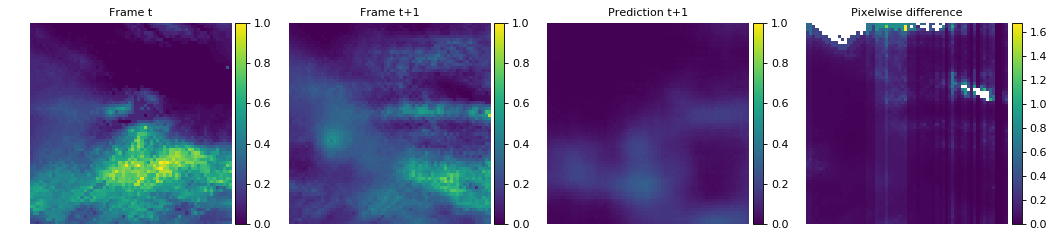

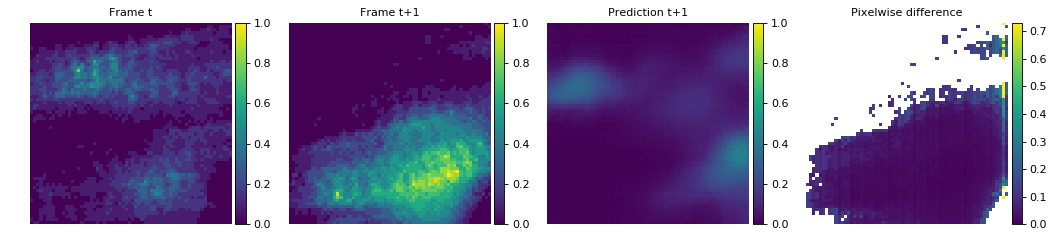

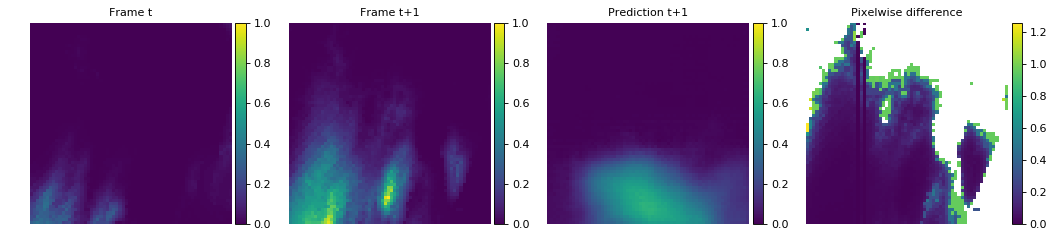

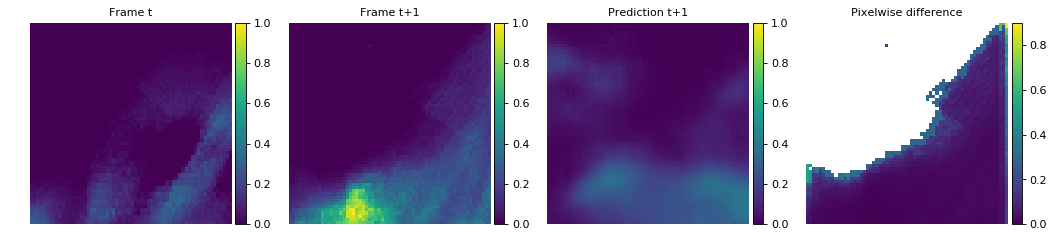

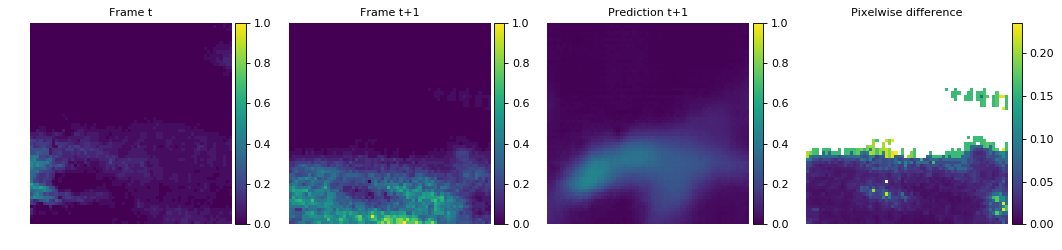

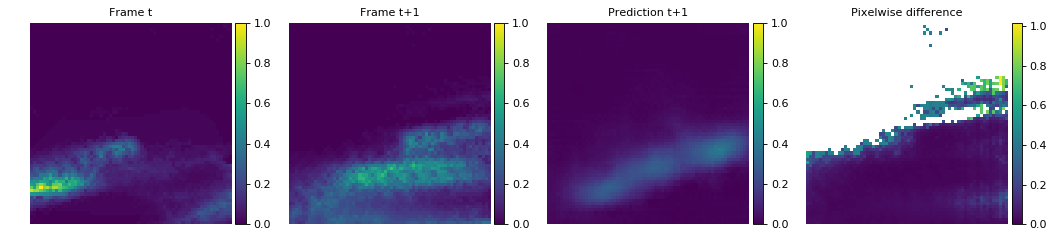

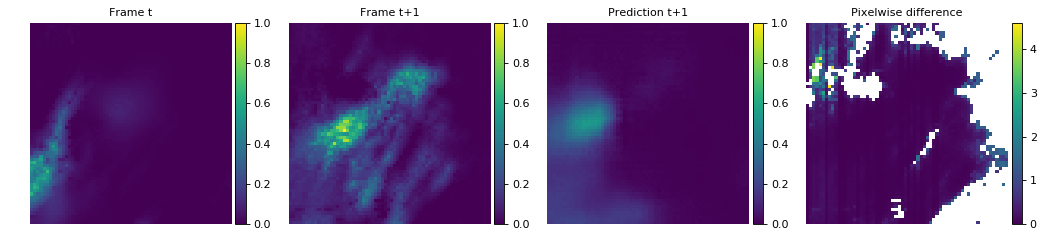

In [61]:
result_plotter(args[:10], (test[:,0,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))

#### VARIATIONAL AUTOENCODER

In [86]:
from keras.layers import Lambda, Flatten

batch_size = 128
latent_dim = 32
epsilon_std = 0.0001

input_img = Input(batch_shape=(batch_size, 64, 64, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

flat_x = Flatten()(encoded)
z_mean = Dense(latent_dim)(flat_x)
z_log_sigma = Dense(latent_dim)(flat_x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Dense(4*4*8)(z)
tf.reshape(z, [128, 4, 4, 8])

x = Conv2D(8, (3, 3), activation='relu', padding='same')(z)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

vae = Model(input_img, decoded)
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

ValueError: Input 0 is incompatible with layer conv2d_111: expected ndim=4, found ndim=2